<h1> Realistic Botnet Traffic Generation using GANs </h1><br>
Rizwan Hamid Randhawa<br>
Development Notebook
<hr>

This notebook is for a conference publication <hr>


<a id="TOC"></a><h2>Table of Contents</h2>
<br>
<a href='#Setup'> Setup</a><br>
<br>
<a href='#EDA'> Preprocessing </a><br>
<a href='#xgboost botnet detection'> Botnet Detection</a><br>
<a href='#Classification'> Subclass clustering </a><br>
<br>
<a href="#GAN setup"> GAN setup and training</a><br>
<br>
<a href="#Compare GAN Output"> Compare GAN Output</a><br>
<a href="#Generated Data Testing"> Generated Data Testing</a><br>
<a href="#Summary"> Summary of Training Data</a><br>
<br>


<a id="Setup"><h1>Setup</h1></a>

<a href='#TOC'>Table of contents</a>
<br><br>

- Load libraries
- Load common functions
- Load stored datasets
- Use linux for xgboost and tensorflow

In [1]:
# !conda install tensorflow

In [2]:
MAIN_CODE_PATH = '/home/riz/Insync/rhr407@gmail.com/Google Drive - Shared with me/PhD/Development/codes/code-in-prog/project-folder/'
DATA_SET_PATH = '/home/riz/Insync/rhr407@gmail.com/Google Drive - Shared with me/PhD/Development/codes/code-in-prog/Data_set/'

In [3]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

   
import numpy as np
import pandas as pd

from scipy import stats



# from tensorflow.keras import backend
from tensorflow.python.keras import backend


import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import xgboost as xgb

import pickle

import gc
gc.collect()


# Load custom functions

import gan

# For reloading after making changes
import importlib
importlib.reload(gan) 
from gan import *

import pandas as pd

import timeit
# code you want to evaluate




/home/riz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/riz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/riz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/riz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [4]:
%cd $DATA_SET_PATH
!ls

/home/riz/Insync/rhr407@gmail.com/Google Drive - Shared with me/PhD/Development/codes/code-in-prog/Data_set
botnet.data.csv
botnet.testing_data.csv
check_data.csv
class_labels.csv
creditcard.csv
credit_card_data
data.csv
DATA.csv
Friday-WorkingHours.pcap_Flow.csv
Friday-WorkingHours.pcap_Flow.pkl
gen_data_set.csv
ISCX_Botnet-Testing.pcap_Flow.csv
ISCX_Botnet-Training.pcap_Flow.csv
ISCX_Botnet-Training-time-correction-done.pcap_Flow.csv
testing_data.csv
testing_DATA.csv


In [5]:
# Save engineered dataset for use in analysis
# Save as pickle for faster reload

data = pd.read_csv (r'data.csv', low_memory=False)
data= data.drop(['Unnamed: 0'], axis=1)

testing_data = pd.read_csv (r'testing_data.csv', low_memory=False)
testing_data= testing_data.drop(['Unnamed: 0'], axis=1)

class_labels = pd.read_csv (r'class_labels.csv', low_memory=False)

<a id="botnet detection"><h1>No Augmentation</h1></a> 

In [6]:
from sklearn.metrics import recall_score, precision_score, accuracy_score

train_df = data.reset_index(drop=True)
test_df = testing_data.reset_index(drop=True)

print( 'train, test: ', len(train_df), len(test_df) )

no_aug_accu_list = []
no_aug_rcl_list = []
no_aug_prec_list = []

rData_aug_accu_list = []
rData_aug_rcl_list = []
rData_aug_prec_list = []

uGAN_aug_accu_list = []
uGAN_aug_rcl_list = []
uGAN_aug_prec_list = []

GAN_aug_accu_list = []
GAN_aug_rcl_list = []
GAN_aug_prec_list = []

train, test:  356156 309187


In [7]:
train_df = data.reset_index(drop=True)
test_df = testing_data.reset_index(drop=True)

y_true = train_df['Label'].values

print( 'train, test: ', len(train_df), len(test_df) )

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]

dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

train, test:  356156 309187


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [8]:
def run_xgb(accu_list, rcl_list, prec_list, X_col, y_col, dtrain, dtest ):
    print('Running XGB...')
    with tf.device("/gpu:1"):
        results_dict = {}

        xgb_params = {
            'max_depth': 4,
            'objective': 'binary:logistic',
            'random_state': 0,
            'eval_metric': 'auc', # auc, error
        #     'tree_method': 'hist'
        #     'grow_policy': 'lossguide' # depthwise, lossguide
        }

        xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                             verbose_eval=False,
                             early_stopping_rounds=20, 
                             evals=[(dtrain,'train'),(dtest,'test')],
                             evals_result = results_dict,     
                             feval = recall, maximize=True  
        #                      feval = roc_auc, maximize=True
                            )

        y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
        y_test = test_df['Label'].values   

        accu = accuracy_score(y_test, np.round(y_pred), normalize=True).round(2)
        rcl = recall_score(y_test, np.round(y_pred)).round(2)
        prec = precision_score(y_test, np.round(y_pred)).round(2)

        accu_list.append(accu)
        rcl_list.append(rcl)
        prec_list.append(prec)

        print( 'Accuracy: ' + str(accu_list) + str('%'))
        print( 'Recall: ' + str(rcl_list) + str('%'))
        print( 'Precision: ' + str(prec_list) + str('%') + '\n\n')

In [9]:
run_xgb(no_aug_accu_list, no_aug_rcl_list, no_aug_prec_list, X_col, y_col, dtrain, dtest )

Running XGB...
Accuracy: [0.38]%
Recall: [0.43]%
Precision: [0.47]%




In [10]:
X_train = train_df[X_col].values
y_train = train_df[y_col].values

X_test = test_df[X_col].values
y_test = test_df[y_col].values

In [11]:
def clsfr_train_test(accu_list = [], rcl_list = [], prec_list = [], clf = 0):
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    accu = accuracy_score(y_test, np.round(y_pred), normalize=True).round(2)
    rcl = recall_score(y_test, np.round(y_pred)).round(2)
    prec = precision_score(y_test, np.round(y_pred)).round(2)
    
    accu_list.append(accu)
    rcl_list.append(rcl)
    prec_list.append(prec)
    
    print( 'Accuracy: ' + str(accu_list) + str('%'))
    print( 'Recall: ' + str(rcl_list) + str('%'))
    print( 'Precision: ' + str(prec_list) + str('%') + '\n\n')

In [12]:
def run_clfrs(accu_list, rcl_list, prec_list):
    with tf.device("/gpu:1"):
        print('Running RF...')
        clsfr_train_test(accu_list, rcl_list, prec_list, clf=RandomForestClassifier(n_estimators=100) )

        print('Running DT...')
        clsfr_train_test( accu_list, rcl_list, prec_list, clf=DecisionTreeClassifier())

        print('Running LR...')
        clsfr_train_test(accu_list, rcl_list, prec_list, clf=LogisticRegression(max_iter=1000))

        print('Running KNN...')
        clsfr_train_test( accu_list, rcl_list, prec_list, clf=KNeighborsClassifier(n_neighbors=5))

        print('Running NB...')
        clsfr_train_test( accu_list, rcl_list, prec_list, clf=GaussianNB() )

        print('Accuracy List:' + str(accu_list))
        print('Recall List:' + str(rcl_list))
        print('Precision List:' + str(prec_list))    

In [13]:
%%time

run_clfrs(no_aug_accu_list, no_aug_rcl_list, no_aug_prec_list)

Running RF...
Accuracy: [0.38, 0.42]%
Recall: [0.43, 0.03]%
Precision: [0.47, 0.62]%


Running DT...
Accuracy: [0.38, 0.42, 0.36]%
Recall: [0.43, 0.03, 0.3]%
Precision: [0.47, 0.62, 0.43]%


Running LR...
Accuracy: [0.38, 0.42, 0.36, 0.59]%
Recall: [0.43, 0.03, 0.3, 1.0]%
Precision: [0.47, 0.62, 0.43, 0.59]%


Running KNN...
Accuracy: [0.38, 0.42, 0.36, 0.59, 0.59]%
Recall: [0.43, 0.03, 0.3, 1.0, 0.98]%
Precision: [0.47, 0.62, 0.43, 0.59, 0.59]%


Running NB...
Accuracy: [0.38, 0.42, 0.36, 0.59, 0.59, 0.41]%
Recall: [0.43, 0.03, 0.3, 1.0, 0.98, 0.0]%
Precision: [0.47, 0.62, 0.43, 0.59, 0.59, 0.93]%


Accuracy List:[0.38, 0.42, 0.36, 0.59, 0.59, 0.41]
Recall List:[0.43, 0.03, 0.3, 1.0, 0.98, 0.0]
Precision List:[0.47, 0.62, 0.43, 0.59, 0.59, 0.93]
CPU times: user 29min 51s, sys: 15min 57s, total: 45min 49s
Wall time: 16min 44s


<a id="botnet detection"><h1>rData Augmentation</h1></a>


In [14]:
bots = data.loc[ data['Label']==1 ].copy() # Real Botnets
gen_data_set = pd.concat([data, bots]) #Augmenting with real botnets

gen_benign_counts = gen_data_set['Label'].value_counts()[0]
print(gen_benign_counts)

train_df = gen_data_set.reset_index(drop=True)
test_df = testing_data.reset_index(drop=True)

dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

242476


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [15]:
run_xgb(rData_aug_accu_list, rData_aug_rcl_list, rData_aug_prec_list, X_col, y_col, dtrain, dtest )

Running XGB...
Accuracy: [0.48]%
Recall: [0.63]%
Precision: [0.55]%




In [16]:
X_train = train_df[X_col].values
y_train = train_df[y_col].values

X_test = test_df[X_col].values
y_test = test_df[y_col].values

In [17]:
%%time

run_clfrs(rData_aug_accu_list, rData_aug_rcl_list, rData_aug_prec_list)

Running RF...
Accuracy: [0.48, 0.42]%
Recall: [0.63, 0.02]%
Precision: [0.55, 0.65]%


Running DT...
Accuracy: [0.48, 0.42, 0.53]%
Recall: [0.63, 0.02, 0.34]%
Precision: [0.55, 0.65, 0.72]%


Running LR...
Accuracy: [0.48, 0.42, 0.53, 0.59]%
Recall: [0.63, 0.02, 0.34, 1.0]%
Precision: [0.55, 0.65, 0.72, 0.59]%


Running KNN...
Accuracy: [0.48, 0.42, 0.53, 0.59, 0.59]%
Recall: [0.63, 0.02, 0.34, 1.0, 0.99]%
Precision: [0.55, 0.65, 0.72, 0.59, 0.59]%


Running NB...
Accuracy: [0.48, 0.42, 0.53, 0.59, 0.59, 0.41]%
Recall: [0.63, 0.02, 0.34, 1.0, 0.99, 0.0]%
Precision: [0.55, 0.65, 0.72, 0.59, 0.59, 0.93]%


Accuracy List:[0.48, 0.42, 0.53, 0.59, 0.59, 0.41]
Recall List:[0.63, 0.02, 0.34, 1.0, 0.99, 0.0]
Precision List:[0.55, 0.65, 0.72, 0.59, 0.59, 0.93]
CPU times: user 41min 8s, sys: 22min 10s, total: 1h 3min 19s
Wall time: 22min 14s


<a id="botnet detection"><h1>uGANs</h1></a>


In [18]:
uGAN_accu_list = []
uGAN_rcl_list = []
uGAN_prec_list = []

uCGAN_accu_list = []
uCGAN_rcl_list = []
uCGAN_prec_list = []

uWGAN_accu_list = []
uWGAN_rcl_list = []
uWGAN_prec_list = []

uWCGAN_accu_list = []
uWCGAN_rcl_list = []
uWCGAN_prec_list = []

_accu_list = []
_rcl_list = []
_prec_list = []

In [22]:
del uGAN_accu_list[:]
del uGAN_rcl_list[:]
del uGAN_prec_list[:]

del uCGAN_accu_list[:]
del uCGAN_rcl_list[:]
del uCGAN_prec_list[:]

del uWGAN_accu_list[:]
del uWGAN_rcl_list[:]
del uWGAN_prec_list[:]

del uWCGAN_accu_list[:]
del uWCGAN_rcl_list[:]
del uWCGAN_prec_list[:]

del _accu_list[:]
del _rcl_list[:]
del _prec_list[:]

In [23]:
import gan
import importlib
importlib.reload(gan) # For reloading after making changes
from gan import *

train = data.loc[ data['Label']==1 ].copy()
label_cols = [ i for i in train.columns if 'Label' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]

rand_dim = train.shape[1] 

seed = 0
base_n_count = 128

data_dim = len(data_cols)
label_dim = len(label_cols)

test_size = 113680 # Equal to all of the botnet flows

x = get_data_batch(train, test_size, seed=0)
Z = np.random.normal(size=(test_size, rand_dim), scale =0.02)

K.set_learning_phase(0)  # 0 = test



GAN_weight_index = 0
print('GAN_weight_index: ' + str(GAN_weight_index))

for prefix in ['GAN', 'CGAN', 'WGAN', 'WCGAN']:
# for prefix in ['WCGAN']:

    
    CACHE_PATH = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-cache/'+prefix+'/'
    FIGS_PATH = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/'+prefix+'/'
    [combined_loss, disc_loss_generated, disc_loss_real, xgb_losses, svm_losses, dt_losses, nb_losses, knn_losses, rf_losses, lr_losses] = pickle.load(open(CACHE_PATH+prefix+'_losses_step_'+str(int(GAN_weight_index))+'.pkl','rb'))

    
    if prefix == 'GAN':
        generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count)
        generator_model.load_weights(CACHE_PATH +'GAN_generator_model_weights_step_' + str(GAN_weight_index) + '.h5')
        _accu_list = uGAN_accu_list
        _rcl_list = uGAN_rcl_list
        _prec_list = uGAN_prec_list
        
        z = Z
        label_cols = []
        
    elif prefix == 'CGAN':
        
        generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count)
        generator_model.load_weights(CACHE_PATH +'CGAN_generator_model_weights_step_' + str(GAN_weight_index) + '.h5')
        _accu_list = uCGAN_accu_list
        _rcl_list = uCGAN_rcl_list
        _prec_list = uCGAN_prec_list
        
        label_cols = [ i for i in train.columns if 'Label' in i ]      
        z = [Z,class_labels ]
        
    elif prefix == 'WGAN':
        generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count, type='Wasserstein')
        generator_model.load_weights(CACHE_PATH +'WGAN_generator_model_weights_step_' + str(GAN_weight_index) + '.h5')
        _accu_list = uWGAN_accu_list
        _rcl_list = uWGAN_rcl_list
        _prec_list = uWGAN_prec_list
        
        label_cols = []
        z = Z
        
    elif prefix == 'WCGAN':
        generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
        generator_model.load_weights(CACHE_PATH +'WCGAN_generator_model_weights_step_' + str(GAN_weight_index) + '.h5')
        _accu_list = uWCGAN_accu_list
        _rcl_list = uWCGAN_rcl_list
        _prec_list = uWCGAN_prec_list
        
        label_cols = [ i for i in train.columns if 'Label' in i ]      
        z = [Z,class_labels ]
        
    # Now generate some new data
    print('Generating ' + str(prefix) + ' data')



    g_z = generator_model.predict(z)    
    g_z = pd.DataFrame(g_z, columns=data_cols+label_cols)    
    g_z.loc[:, 'Label'] = 1
    
    gen_data_set = pd.concat([data, g_z])
    gen_data_set = gen_data_set.reset_index(drop=True)

    gen_benign_counts = gen_data_set['Label'].value_counts()[0]
    print(gen_benign_counts)
    
    gen_benign_counts = gen_data_set['Label'].value_counts()[1]
    print(gen_benign_counts)

    train_df = gen_data_set.reset_index(drop=True)
    test_df = testing_data.reset_index(drop=True)
    
    
    dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

    run_xgb(_accu_list, _rcl_list, _prec_list, X_col, y_col, dtrain, dtest )
    
    X_train = train_df[X_col].values
    y_train = train_df[y_col].values

    X_test = test_df[X_col].values
    y_test = test_df[y_col].values
    
    run_clfrs(_accu_list, _rcl_list, _prec_list)

GAN_weight_index: 0
Generating GAN data
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running XGB...
Accuracy: [0.6]%
Recall: [0.84]%
Precision: [0.62]%


Running RF...
Accuracy: [0.6, 0.42]%
Recall: [0.84, 0.03]%
Precision: [0.62, 0.7]%


Running DT...
Accuracy: [0.6, 0.42, 0.49]%
Recall: [0.84, 0.03, 0.29]%
Precision: [0.62, 0.7, 0.64]%


Running LR...
Accuracy: [0.6, 0.42, 0.49, 0.59]%
Recall: [0.84, 0.03, 0.29, 1.0]%
Precision: [0.62, 0.7, 0.64, 0.59]%


Running KNN...
Accuracy: [0.6, 0.42, 0.49, 0.59, 0.59]%
Recall: [0.84, 0.03, 0.29, 1.0, 0.98]%
Precision: [0.62, 0.7, 0.64, 0.59, 0.59]%


Running NB...
Accuracy: [0.6, 0.42, 0.49, 0.59, 0.59, 0.41]%
Recall: [0.84, 0.03, 0.29, 1.0, 0.98, 0.0]%
Precision: [0.62, 0.7, 0.64, 0.59, 0.59, 0.79]%


Accuracy List:[0.6, 0.42, 0.49, 0.59, 0.59, 0.41]
Recall List:[0.84, 0.03, 0.29, 1.0, 0.98, 0.0]
Precision List:[0.62, 0.7, 0.64, 0.59, 0.59, 0.79]
Generating CGAN data
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running XGB...
Accuracy: [0.58]%
Recall: [0.99]%
Precision: [0.59]%


Running RF...
Accuracy: [0.58, 0.42]%
Recall: [0.99, 0.02]%
Precision: [0.59, 0.62]%


Running DT...
Accuracy: [0.58, 0.42, 0.38]%
Recall: [0.99, 0.02, 0.04]%
Precision: [0.59, 0.62, 0.28]%


Running LR...
Accuracy: [0.58, 0.42, 0.38, 0.59]%
Recall: [0.99, 0.02, 0.04, 1.0]%
Precision: [0.59, 0.62, 0.28, 0.59]%


Running KNN...
Accuracy: [0.58, 0.42, 0.38, 0.59, 0.59]%
Recall: [0.99, 0.02, 0.04, 1.0, 0.98]%
Precision: [0.59, 0.62, 0.28, 0.59, 0.59]%


Running NB...
Accuracy: [0.58, 0.42, 0.38, 0.59, 0.59, 0.41]%
Recall: [0.99, 0.02, 0.04, 1.0, 0.98, 0.0]%
Precision: [0.59, 0.62, 0.28, 0.59, 0.59, 0.86]%


Accuracy List:[0.58, 0.42, 0.38, 0.59, 0.59, 0.41]
Recall List:[0.99, 0.02, 0.04, 1.0, 0.98, 0.0]
Precision List:[0.59, 0.62, 0.28, 0.59, 0.59, 0.86]
Generating WGAN data
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running XGB...
Accuracy: [0.55]%
Recall: [0.46]%
Precision: [0.67]%


Running RF...
Accuracy: [0.55, 0.42]%
Recall: [0.46, 0.02]%
Precision: [0.67, 0.68]%


Running DT...
Accuracy: [0.55, 0.42, 0.63]%
Recall: [0.46, 0.02, 0.5]%
Precision: [0.67, 0.68, 0.79]%


Running LR...
Accuracy: [0.55, 0.42, 0.63, 0.59]%
Recall: [0.46, 0.02, 0.5, 1.0]%
Precision: [0.67, 0.68, 0.79, 0.59]%


Running KNN...
Accuracy: [0.55, 0.42, 0.63, 0.59, 0.59]%
Recall: [0.46, 0.02, 0.5, 1.0, 0.98]%
Precision: [0.67, 0.68, 0.79, 0.59, 0.59]%


Running NB...
Accuracy: [0.55, 0.42, 0.63, 0.59, 0.59, 0.41]%
Recall: [0.46, 0.02, 0.5, 1.0, 0.98, 0.0]%
Precision: [0.67, 0.68, 0.79, 0.59, 0.59, 0.96]%


Accuracy List:[0.55, 0.42, 0.63, 0.59, 0.59, 0.41]
Recall List:[0.46, 0.02, 0.5, 1.0, 0.98, 0.0]
Precision List:[0.67, 0.68, 0.79, 0.59, 0.59, 0.96]
Generating WCGAN data
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running XGB...
Accuracy: [0.59]%
Recall: [1.0]%
Precision: [0.59]%


Running RF...
Accuracy: [0.59, 0.42]%
Recall: [1.0, 0.03]%
Precision: [0.59, 0.65]%


Running DT...
Accuracy: [0.59, 0.42, 0.42]%
Recall: [1.0, 0.03, 0.19]%
Precision: [0.59, 0.65, 0.52]%


Running LR...
Accuracy: [0.59, 0.42, 0.42, 0.59]%
Recall: [1.0, 0.03, 0.19, 1.0]%
Precision: [0.59, 0.65, 0.52, 0.59]%


Running KNN...
Accuracy: [0.59, 0.42, 0.42, 0.59, 0.59]%
Recall: [1.0, 0.03, 0.19, 1.0, 0.98]%
Precision: [0.59, 0.65, 0.52, 0.59, 0.59]%


Running NB...
Accuracy: [0.59, 0.42, 0.42, 0.59, 0.59, 0.41]%
Recall: [1.0, 0.03, 0.19, 1.0, 0.98, 0.0]%
Precision: [0.59, 0.65, 0.52, 0.59, 0.59, 0.85]%


Accuracy List:[0.59, 0.42, 0.42, 0.59, 0.59, 0.41]
Recall List:[1.0, 0.03, 0.19, 1.0, 0.98, 0.0]
Precision List:[0.59, 0.65, 0.52, 0.59, 0.59, 0.85]


In [24]:

GAN_accu_list = []
GAN_rcl_list = []
GAN_prec_list = []

CGAN_accu_list = []
CGAN_rcl_list = []
CGAN_prec_list = []

WGAN_accu_list = []
WGAN_rcl_list = []
WGAN_prec_list = []

WCGAN_accu_list = []
WCGAN_rcl_list = []
WCGAN_prec_list = []

_accu_list = []
_rcl_list = []
_prec_list = []

In [25]:
# del GAN_accu_list[:]
# del GAN_rcl_list[:]
# del GAN_prec_list[:]

# del CGAN_accu_list[:]
# del CGAN_rcl_list[:]
# del CGAN_prec_list[:]

# del WGAN_accu_list[:]
# del WGAN_rcl_list[:]
# del WGAN_prec_list[:]

# del WCGAN_accu_list[:]
# del WCGAN_rcl_list[:]
# del WCGAN_prec_list[:]

# del _accu_list[:]
# del _rcl_list[:]
# del _prec_list[:]

In [27]:
import gan
import importlib
importlib.reload(gan) # For reloading after making changes
from gan import *

#===========================================================================
train = data.loc[ data['Label']==1 ].copy()
label_cols = [ i for i in train.columns if 'Label' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]

rand_dim = train.shape[1] 

seed = 0
base_n_count = 128

data_dim = len(data_cols)
label_dim = len(label_cols)

test_size = 113680 # Equal to all of the botnet flows

x = get_data_batch(train, test_size, seed=0)
Z = np.random.normal(size=(test_size, rand_dim), scale =0.02)

K.set_learning_phase(0)  # 0 = test
#===========================================================================

result_shape = 129056
batch_size = 16384
required_epochs = 100
GAN_weight_index = required_epochs * result_shape // batch_size
#===========================================================================

for prefix in ['GAN', 'CGAN', 'WGAN', 'WCGAN']:
# for prefix in ['CGAN']:
    
    if prefix == 'WCGAN':
        GAN_weight_index = 399

    print('GAN_weight_index: ' + str(GAN_weight_index))
    CACHE_PATH = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-cache/'+prefix+'/'
    FIGS_PATH = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/'+prefix+'/'
    [combined_loss, disc_loss_generated, disc_loss_real, xgb_losses, svm_losses, dt_losses, nb_losses, knn_losses, rf_losses, lr_losses] = pickle.load(open(CACHE_PATH+prefix+'_losses_step_'+str(int(GAN_weight_index))+'.pkl','rb'))
#===================================================================================================================
    best_xgb = xgb_losses.tolist().index(xgb_losses.min())
    best_rf = rf_losses.tolist().index(rf_losses.min())
    best_dt = dt_losses.tolist().index(dt_losses.min())
    best_lr = lr_losses.tolist().index(lr_losses.min())
    best_knn = knn_losses.tolist().index(knn_losses.min())
    best_nb = nb_losses.tolist().index(nb_losses.min())

    best_indices_list = [best_xgb, best_rf, best_dt, best_lr, best_knn, best_nb] 
    print('Best indices: ' + str(best_indices_list))
#===================================================================================================================
    print('Selected Model is: '+ str(prefix))
    for indx in best_indices_list:        
        
        if prefix == 'GAN':
            generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count)
            generator_model.load_weights(CACHE_PATH +'GAN_generator_model_weights_step_' + str(indx) + '.h5')
            _accu_list = GAN_accu_list
            _rcl_list = GAN_rcl_list
            _prec_list = GAN_prec_list


            label_cols = []
            z = Z

        elif prefix == 'CGAN':

            generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count)
            generator_model.load_weights(CACHE_PATH +'CGAN_generator_model_weights_step_' + str(indx) + '.h5')
            _accu_list = CGAN_accu_list
            _rcl_list = CGAN_rcl_list
            _prec_list = CGAN_prec_list

            label_cols = [ i for i in train.columns if 'Label' in i ]
            print(label_cols)
            z = [Z, class_labels ]
            

        elif prefix == 'WGAN':
            generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count, type='Wasserstein')
            generator_model.load_weights(CACHE_PATH +'WGAN_generator_model_weights_step_' + str(indx) + '.h5')
            _accu_list = WGAN_accu_list
            _rcl_list = WGAN_rcl_list
            _prec_list = WGAN_prec_list

            label_cols = []
            z = Z

        elif prefix == 'WCGAN':
            generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
            generator_model.load_weights(CACHE_PATH +'WCGAN_generator_model_weights_step_' + str(indx) + '.h5')
            _accu_list = WCGAN_accu_list
            _rcl_list = WCGAN_rcl_list
            _prec_list = WCGAN_prec_list

            label_cols = [ i for i in train.columns if 'Label' in i ]      
            z = [Z, class_labels ]
        
        ####################################################################
        # Now generate some new data
        print('Generating ' + str(prefix) + ' data for ' + str(indx))


        g_z = generator_model.predict(z)    
        g_z = pd.DataFrame(g_z, columns=data_cols+label_cols)    
        g_z.loc[:, 'Label'] = 1

        gen_data_set = pd.concat([data, g_z])
        gen_data_set = gen_data_set.reset_index(drop=True)

        gen_benign_counts = gen_data_set['Label'].value_counts()[0]
        print(gen_benign_counts)

        gen_benign_counts = gen_data_set['Label'].value_counts()[1]
        print(gen_benign_counts)

        train_df = gen_data_set.reset_index(drop=True)
        test_df = testing_data.reset_index(drop=True)


        dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
        dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)
        
        if best_indices_list.index(indx) == 0 :            

            dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
            dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

            run_xgb(_accu_list, _rcl_list, _prec_list, X_col, y_col, dtrain, dtest )


##########################################################################


        X_train = train_df[X_col].values
        y_train = train_df[y_col].values

        X_test = test_df[X_col].values
        y_test = test_df[y_col].values


        with tf.device("/gpu:1"):
            if best_indices_list.index(indx) == 1 :
                print('Running RF...')
                clsfr_train_test(_accu_list, _rcl_list, _prec_list, clf=RandomForestClassifier(n_estimators=100))
            if best_indices_list.index(indx) == 2 :
                print('Running DT...')
                clsfr_train_test(_accu_list, _rcl_list, _prec_list, clf=DecisionTreeClassifier())
            if best_indices_list.index(indx) == 3 :
                print('Running LR...')
                clsfr_train_test(_accu_list, _rcl_list, _prec_list, clf=LogisticRegression(max_iter=1000))
            if best_indices_list.index(indx) == 4 :
                print('Running KNN...')
                clsfr_train_test(_accu_list, _rcl_list, _prec_list, clf=KNeighborsClassifier(n_neighbors=5))
            if best_indices_list.index(indx) == 5 :
                print('Running NB...')
                clsfr_train_test(_accu_list, _rcl_list, _prec_list, clf=GaussianNB())


GAN_weight_index: 787
Best indices: [52, 0, 25, 2, 0, 0]
Selected Model is: GAN
Generating GAN data for 52
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running XGB...
Accuracy: [0.59]%
Recall: [0.96]%
Precision: [0.59]%


Generating GAN data for 0
242476
227360
Running RF...
Accuracy: [0.59, 0.42]%
Recall: [0.96, 0.03]%
Precision: [0.59, 0.66]%


Generating GAN data for 25
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running DT...
Accuracy: [0.59, 0.42, 0.49]%
Recall: [0.96, 0.03, 0.28]%
Precision: [0.59, 0.66, 0.64]%


Generating GAN data for 2
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running LR...
Accuracy: [0.59, 0.42, 0.49, 0.59]%
Recall: [0.96, 0.03, 0.28, 1.0]%
Precision: [0.59, 0.66, 0.64, 0.59]%


Generating GAN data for 0
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running RF...
Accuracy: [0.59, 0.42, 0.49, 0.59, 0.42]%
Recall: [0.96, 0.03, 0.28, 1.0, 0.03]%
Precision: [0.59, 0.66, 0.64, 0.59, 0.62]%


Generating GAN data for 0
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running RF...
Accuracy: [0.59, 0.42, 0.49, 0.59, 0.42, 0.42]%
Recall: [0.96, 0.03, 0.28, 1.0, 0.03, 0.02]%
Precision: [0.59, 0.66, 0.64, 0.59, 0.62, 0.62]%


GAN_weight_index: 787
Best indices: [23, 107, 23, 0, 0, 0]
Selected Model is: CGAN
['Label']
Generating CGAN data for 23
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running XGB...
Accuracy: [0.59]%
Recall: [0.98]%
Precision: [0.59]%


['Label']
Generating CGAN data for 107
242476
227360
Running RF...
Accuracy: [0.59, 0.42]%
Recall: [0.98, 0.02]%
Precision: [0.59, 0.63]%


['Label']
Generating CGAN data for 23
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running XGB...
Accuracy: [0.59, 0.42, 0.59]%
Recall: [0.98, 0.02, 0.98]%
Precision: [0.59, 0.63, 0.59]%


['Label']
Generating CGAN data for 0
242476
227360
Running LR...
Accuracy: [0.59, 0.42, 0.59, 0.59]%
Recall: [0.98, 0.02, 0.98, 1.0]%
Precision: [0.59, 0.63, 0.59, 0.59]%


['Label']
Generating CGAN data for 0
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running LR...
Accuracy: [0.59, 0.42, 0.59, 0.59, 0.59]%
Recall: [0.98, 0.02, 0.98, 1.0, 1.0]%
Precision: [0.59, 0.63, 0.59, 0.59, 0.59]%


['Label']
Generating CGAN data for 0
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running LR...
Accuracy: [0.59, 0.42, 0.59, 0.59, 0.59, 0.59]%
Recall: [0.98, 0.02, 0.98, 1.0, 1.0, 1.0]%
Precision: [0.59, 0.63, 0.59, 0.59, 0.59, 0.59]%


GAN_weight_index: 787
Best indices: [77, 0, 34, 92, 27, 104]
Selected Model is: WGAN
Generating WGAN data for 77
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running XGB...
Accuracy: [0.59]%
Recall: [1.0]%
Precision: [0.59]%


Generating WGAN data for 0
242476
227360
Running RF...
Accuracy: [0.59, 0.42]%
Recall: [1.0, 0.02]%
Precision: [0.59, 0.64]%


Generating WGAN data for 34
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running DT...
Accuracy: [0.59, 0.42, 0.56]%
Recall: [1.0, 0.02, 0.39]%
Precision: [0.59, 0.64, 0.73]%


Generating WGAN data for 92
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running LR...
Accuracy: [0.59, 0.42, 0.56, 0.59]%
Recall: [1.0, 0.02, 0.39, 1.0]%
Precision: [0.59, 0.64, 0.73, 0.59]%


Generating WGAN data for 27
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running KNN...
Accuracy: [0.59, 0.42, 0.56, 0.59, 0.59]%
Recall: [1.0, 0.02, 0.39, 1.0, 0.98]%
Precision: [0.59, 0.64, 0.73, 0.59, 0.59]%


Generating WGAN data for 104
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running NB...
Accuracy: [0.59, 0.42, 0.56, 0.59, 0.59, 0.41]%
Recall: [1.0, 0.02, 0.39, 1.0, 0.98, 0.0]%
Precision: [0.59, 0.64, 0.73, 0.59, 0.59, 0.98]%


GAN_weight_index: 399
Best indices: [57, 0, 44, 42, 19, 85]
Selected Model is: WCGAN
Generating WCGAN data for 57
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running XGB...
Accuracy: [0.59]%
Recall: [1.0]%
Precision: [0.59]%


Generating WCGAN data for 0
242476
227360
Running RF...
Accuracy: [0.59, 0.42]%
Recall: [1.0, 0.02]%
Precision: [0.59, 0.62]%


Generating WCGAN data for 44
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running DT...
Accuracy: [0.59, 0.42, 0.51]%
Recall: [1.0, 0.02, 0.31]%
Precision: [0.59, 0.62, 0.67]%


Generating WCGAN data for 42
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running LR...
Accuracy: [0.59, 0.42, 0.51, 0.59]%
Recall: [1.0, 0.02, 0.31, 1.0]%
Precision: [0.59, 0.62, 0.67, 0.59]%


Generating WCGAN data for 19
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running KNN...
Accuracy: [0.59, 0.42, 0.51, 0.59, 0.59]%
Recall: [1.0, 0.02, 0.31, 1.0, 0.98]%
Precision: [0.59, 0.62, 0.67, 0.59, 0.59]%


Generating WCGAN data for 85
242476
227360


/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/riz/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Running NB...
Accuracy: [0.59, 0.42, 0.51, 0.59, 0.59, 0.41]%
Recall: [1.0, 0.02, 0.31, 1.0, 0.98, 0.0]%
Precision: [0.59, 0.62, 0.67, 0.59, 0.59, 0.98]%




In [28]:
# GAN_aug_accu_list.pop(0)
# GAN_aug_rcl_list.pop(0)
# GAN_aug_prec_list.pop(0)

In [29]:
print(uGAN_accu_list)
print(uGAN_rcl_list)
print(uGAN_prec_list)

print(uCGAN_accu_list)
print(uCGAN_rcl_list)
print(uCGAN_prec_list)

print(uWGAN_accu_list)
print(uWGAN_rcl_list)
print(uWGAN_prec_list)

print(uWCGAN_accu_list)
print(uWCGAN_rcl_list)
print(uWCGAN_prec_list)

print(GAN_accu_list)
print(GAN_rcl_list)
print(GAN_prec_list)

print(CGAN_accu_list)
print(CGAN_rcl_list)
print(CGAN_prec_list)

print(WGAN_accu_list)
print(WGAN_rcl_list)
print(WGAN_prec_list)

print(WCGAN_accu_list)
print(WCGAN_rcl_list)
print(WCGAN_prec_list)

[0.6, 0.42, 0.49, 0.59, 0.59, 0.41]
[0.84, 0.03, 0.29, 1.0, 0.98, 0.0]
[0.62, 0.7, 0.64, 0.59, 0.59, 0.79]
[0.58, 0.42, 0.38, 0.59, 0.59, 0.41]
[0.99, 0.02, 0.04, 1.0, 0.98, 0.0]
[0.59, 0.62, 0.28, 0.59, 0.59, 0.86]
[0.55, 0.42, 0.63, 0.59, 0.59, 0.41]
[0.46, 0.02, 0.5, 1.0, 0.98, 0.0]
[0.67, 0.68, 0.79, 0.59, 0.59, 0.96]
[0.59, 0.42, 0.42, 0.59, 0.59, 0.41]
[1.0, 0.03, 0.19, 1.0, 0.98, 0.0]
[0.59, 0.65, 0.52, 0.59, 0.59, 0.85]
[0.59, 0.42, 0.49, 0.59, 0.42, 0.42]
[0.96, 0.03, 0.28, 1.0, 0.03, 0.02]
[0.59, 0.66, 0.64, 0.59, 0.62, 0.62]
[0.59, 0.42, 0.59, 0.59, 0.59, 0.59]
[0.98, 0.02, 0.98, 1.0, 1.0, 1.0]
[0.59, 0.63, 0.59, 0.59, 0.59, 0.59]
[0.59, 0.42, 0.56, 0.59, 0.59, 0.41]
[1.0, 0.02, 0.39, 1.0, 0.98, 0.0]
[0.59, 0.64, 0.73, 0.59, 0.59, 0.98]
[0.59, 0.42, 0.51, 0.59, 0.59, 0.41]
[1.0, 0.02, 0.31, 1.0, 0.98, 0.0]
[0.59, 0.62, 0.67, 0.59, 0.59, 0.98]


In [82]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

barWidth = 0.2  # the width of the bars

labels = ['XGB', 'RF','DT', 'LR', 'KNN', 'NB']

 # Set position of bar on X axis
r1 = np.arange(len(no_aug_rcl_list))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]



x = np.arange(len(labels))  # the label locations

def plot_metric(_list1 = [], _list2 = [], _list3 = [], _list4 = [], X_label = '', _label1 = '', _label2 = '', _label3 = '', _label4 = '' , fig_path = ''):

    fig, ax = plt.subplots(1, 1, figsize=(4.4, 2.75))

    rects1 = ax.bar(r1, _list1, barWidth, label=_label1, color='#F08080')
    rects2 = ax.bar(r2, _list2, barWidth, label=_label2, color='#DC143C')
    rects3 = ax.bar(r3, _list3, barWidth, label=_label3, color='#4169D0')
    rects4 = ax.bar(r4, _list4, barWidth, label=_label4, color='#6495ED')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Fraction')
    ax.set_title(X_label)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, ha='center')
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


#     autolabel(rects1)
#     autolabel(rects2)
#     autolabel(rects3)
#     autolabel(rects4)

    fig.tight_layout()
    plt.savefig(fig_path)

    plt.show()

    

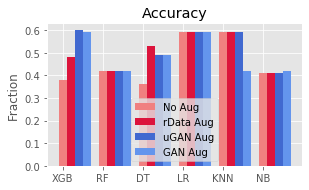

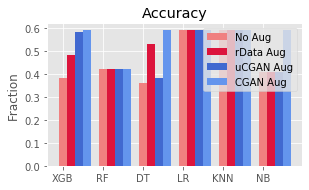

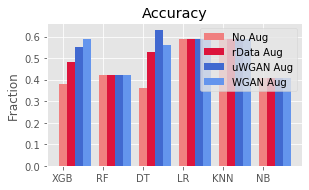

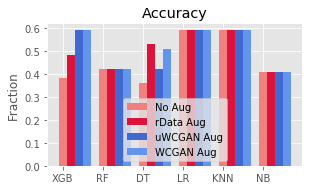

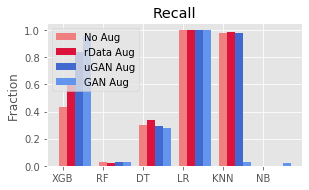

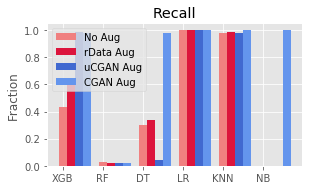

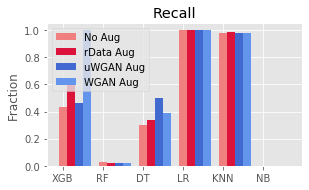

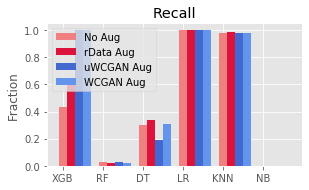

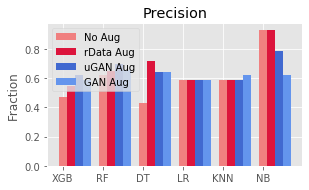

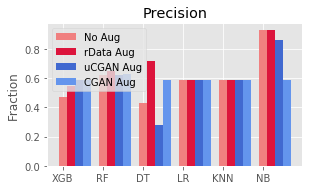

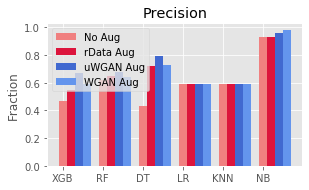

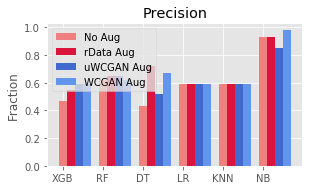

In [83]:
plot_metric(no_aug_accu_list, rData_aug_accu_list, uGAN_accu_list, GAN_accu_list, X_label = 'Accuracy', _label1 = 'No Aug', _label2 = 'rData Aug', _label3 = 'uGAN Aug', _label4 = 'GAN Aug' , fig_path = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/selectedPlots-2/GAN_Accu.svg')

plot_metric(no_aug_accu_list, rData_aug_accu_list, uCGAN_accu_list, CGAN_accu_list, X_label = 'Accuracy', _label1 = 'No Aug', _label2 = 'rData Aug', _label3 = 'uCGAN Aug', _label4 = 'CGAN Aug', fig_path = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/selectedPlots-2/CGAN_Accu.svg')

plot_metric(no_aug_accu_list, rData_aug_accu_list, uWGAN_accu_list, WGAN_accu_list, X_label = 'Accuracy',  _label1 = 'No Aug', _label2 = 'rData Aug', _label3 = 'uWGAN Aug', _label4 = 'WGAN Aug' , fig_path = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/selectedPlots-2/WGAN_Accu.svg')

plot_metric(no_aug_accu_list, rData_aug_accu_list, uWCGAN_accu_list, WCGAN_accu_list, X_label = 'Accuracy',  _label1 = 'No Aug', _label2 = 'rData Aug', _label3 = 'uWCGAN Aug', _label4 = 'WCGAN Aug' , fig_path = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/selectedPlots-2/WCGAN_Accu.svg')


plot_metric(no_aug_rcl_list, rData_aug_rcl_list, uGAN_rcl_list, GAN_rcl_list, X_label = 'Recall', _label1 = 'No Aug', _label2 = 'rData Aug', _label3 = 'uGAN Aug', _label4 = 'GAN Aug' , fig_path = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/selectedPlots-2/GAN_Rcl.svg')

plot_metric(no_aug_rcl_list, rData_aug_rcl_list, uCGAN_rcl_list, CGAN_rcl_list, X_label = 'Recall', _label1 = 'No Aug', _label2 = 'rData Aug', _label3 = 'uCGAN Aug', _label4 = 'CGAN Aug', fig_path = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/selectedPlots-2/CGAN_Rcl.svg')

plot_metric(no_aug_rcl_list, rData_aug_rcl_list, uWGAN_rcl_list, WGAN_rcl_list, X_label = 'Recall',  _label1 = 'No Aug', _label2 = 'rData Aug', _label3 = 'uWGAN Aug', _label4 = 'WGAN Aug' , fig_path = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/selectedPlots-2/WGAN_Rcl.svg')

plot_metric(no_aug_rcl_list, rData_aug_rcl_list, uWCGAN_rcl_list, WCGAN_rcl_list, X_label = 'Recall',  _label1 = 'No Aug', _label2 = 'rData Aug', _label3 = 'uWCGAN Aug', _label4 = 'WCGAN Aug' , fig_path = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/selectedPlots-2/WCGAN_Rcl.svg')


plot_metric(no_aug_prec_list, rData_aug_prec_list, uGAN_prec_list, GAN_prec_list, X_label = 'Precision', _label1 = 'No Aug', _label2 = 'rData Aug', _label3 = 'uGAN Aug', _label4 = 'GAN Aug' , fig_path = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/selectedPlots-2/GAN_Prec.svg')

plot_metric(no_aug_prec_list, rData_aug_prec_list, uCGAN_prec_list, CGAN_prec_list, X_label = 'Precision', _label1 = 'No Aug', _label2 = 'rData Aug', _label3 = 'uCGAN Aug', _label4 = 'CGAN Aug', fig_path = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/selectedPlots-2/CGAN_Prec.svg')

plot_metric(no_aug_prec_list, rData_aug_prec_list, uWGAN_prec_list, WGAN_prec_list, X_label = 'Precision',  _label1 = 'No Aug', _label2 = 'rData Aug', _label3 = 'uWGAN Aug', _label4 = 'WGAN Aug', fig_path = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/selectedPlots-2/WGAN_Prec.svg' )

plot_metric(no_aug_prec_list, rData_aug_prec_list, uWCGAN_prec_list, WCGAN_prec_list, X_label = 'Precision',  _label1 = 'No Aug', _label2 = 'rData Aug', _label3 = 'uWCGAN Aug', _label4 = 'WCGAN Aug' , fig_path = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/selectedPlots-2/WCGAN_Prec.svg')

  